# Measuring #21DayLockdown Impact on COVID-19 pandemic spread in India

## A Exponential Mathematical Model for Corona Virus spread using Scipy Curve Fitting

On 22nd March, 2020, India observed a 14-Hour lockdown against Corona virus pandemic when Prime minister of India called out for a public #Lockdown and curfew. 
This was one of the longest country-wide lock and curfew in India with good response. Next few days were critical for virus spread. (Markets were crashing worst of all time.)


### Flattening the Curve:  #21DaysLockdown:

On Night of 23rd March, PM of Government of India announced 100% #21DaysLockdown and extending the Section144 Curfew against the Corona (COVID19) pandemic starting from 24th March, 2020 till 14th April, 2020.

This was the first of its kind of lockdown at such massive scale. 
This triggered a country-wide lockdown of about 100 Crore+ people in their homes in intent to `flatten the curve` of the pandemic.

On 24th of March, nearly 170 Crore people across the World were already in locked-down state in their homes due to the sever spread of the pandemic, killing more than 18,000 people across globe.

### Measuring Impact:

This Jupyter is hypothetical modeling of the corona virus spread by counting the number of cases reported each day (cumulative), in order to check the impact of the #21DaysLockdown by extending (extrapolating) 21 days further from 23rd March and compare with actual reported case.

If a flattening curve appreas against the extrpolated curve, then this 'may' suggest the pandemic is in control in India. And #21DaysLockdown had good impact. 

## Loading & Exploring Data

* Source of the data: [wikipedia](https://en.wikipedia.org/wiki/Timeline_of_the_2020_coronavirus_pandemic_in_India#January)
    

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go 
import plotly.offline as pyo
import matplotlib
%matplotlib inline

In [35]:
df = pd.read_csv("data/covid19-total-cases-india.csv", parse_dates=['Date'])

In [36]:
df.head()

,Date,Commulative Total Count of Confirmed Cases In India
0,2020-03-14,100.0
1,2020-03-15,110.0
2,2020-03-16,114.0
3,2020-03-17,140.0
4,2020-03-18,170.0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
Date                                                   48 non-null datetime64[ns]
Commulative Total Count of Confirmed Cases In India    24 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 896.0 bytes


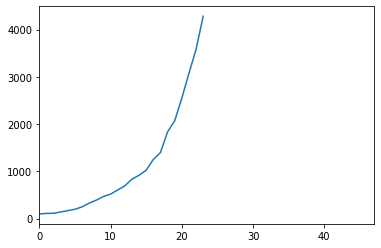

In [38]:
# Basic Plot
df['Commulative Total Count of Confirmed Cases In India'].plot()

### Plotly Interactive Chart

In [39]:
# Plotly Interactive Chart

trace1 = go.Scatter(x=df['Date'],
                    y=df['Commulative Total Count of Confirmed Cases In India'],
                    name="Commulative Total Count of Confirmed Cases In India",
                    mode='lines+markers')

data = [trace1]

layout = go.Layout(title='COVID-19 in India: Commulative Total Count of Confirmed Cases', 
                   xaxis_title="Date",
                   yaxis_title="# Cases",
                   font=dict(
                       family="Courier New, monospace",
                       size=14,
                       color="#000")
                   )


fig = go.Figure(data=data,layout=layout)

pyo.plot(fig,filename="InteractiveCharts/Real-Cases-Count-Chart.html")

'InteractiveCharts/Real-Cases-Count-Chart.html'

## Analyzing the Order of the Curve
When curve is diffrentiated multiple times, after some differenece the series will turn stationary.

Stationarity can be checked using Augmented Dickey Fuller Test:

* `p-value > 0.05`: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* `p-value <= 0.05` : Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Reference: 
* [machinelearningmastery](https://machinelearningmastery.com/time-series-data-stationary-python/)

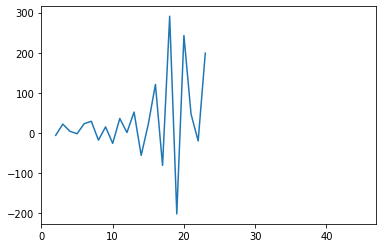

In [44]:
df['Commulative Total Count of Confirmed Cases In India'].diff().diff().plot()

In [46]:
from statsmodels.tsa.stattools import adfuller

# Differntiantion multiple times to make the data stationary
# to confirm data stationarity we use the Augmented Dickey Fuller Test 

X = df['Commulative Total Count of Confirmed Cases In India'].diff().diff().diff().dropna().values

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if(result[1]>0.05):
    print('p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary');

if(result[1]<=0.05):
    print('p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary');


ADF Statistic: -3.795306
p-value: 0.002956
Critical Values:
	1%: -4.138
	5%: -3.155
	10%: -2.714
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


#### Order of the curve is 3
* Hence, need to apply, cubic and exponential curve fitting and check which fits the best 

In [47]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cvfit

In [48]:
# Drop Null values because Scipy will not accept the null values.
x_data = df['Commulative Total Count of Confirmed Cases In India'].dropna().index.values 
x_data

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [49]:
y_data = df['Commulative Total Count of Confirmed Cases In India'].dropna().values
y_data

array([ 100.,  110.,  114.,  140.,  170.,  198.,  249.,  329.,  391.,
        468.,  519.,  606.,  694.,  834.,  918., 1024., 1251., 1397.,
       1834., 2069., 2547., 3072., 3577., 4281.])

In [50]:
# Prepare fit function
def exponential_1(x, a, b, c):
    return a * np.exp(b * x) + c

def exponential_2(x, a, b):
    return a * np.exp(b * x)

def exponential_3(x, a, b): # Warning: Divide by zero
    return a*np.exp(x/b)

# y = a(1 + r)^b : https://mathbitsnotebook.com/Algebra2/Exponential/EXGrowthDecay.html
# r is the rate of growth
def exponential_4(x, a, r):
    return a * np.power(1+r,x)

def cubic_1(x, a):
    return a * np.power(x,3)


In [51]:
# Fit exponential_1
param_exponential_1, param_cov_exponential_1 = cvfit(exponential_1, x_data, y_data) 

# Fit exponential_2
param_exponential_2, param_cov_exponential_2 = cvfit(exponential_2, x_data, y_data) 

# Fit exponential_3
param_exponential_3, param_cov_exponential_3 = cvfit(exponential_3, x_data, y_data) 

def exponential_3(x, a, b):
    return a*np.exp(x/b)


print("Exponential 1 Fit Parameters and Cov:")
print(param_exponential_1)
print(param_cov_exponential_1)

print("\n")

print("Exponential 2 Fit Parameters and Cov:")
print(param_exponential_2)
print(param_cov_exponential_2)


print("\n")

print("Exponential 3 Fit Parameters and Cov:")
print(param_exponential_3)
print(param_cov_exponential_3)

print("\n")

# model for cubic_1
# f(x) = a.x^3 + b.x^2 + c.x + d
cubic_fit = np.polyfit(x_data, y_data, 3)

print("Cubit Fit Parameters:")
for i in cubic_fit:
    print(i)

Exponential 1 Fit Parameters and Cov:
[72.72071634  0.17660713 48.97822938]
[[ 4.00062820e+01 -2.39621772e-02 -1.22846661e+02]
 [-2.39621772e-02  1.44870439e-05  7.09580952e-02]
 [-1.22846661e+02  7.09580952e-02  5.23204725e+02]]


Exponential 2 Fit Parameters and Cov:
[85.05037381  0.17001928]
[[ 1.55207022e+01 -8.71194291e-03]
 [-8.71194291e-03  4.98750879e-06]]


Exponential 3 Fit Parameters and Cov:
[85.05037453  5.88168606]
[[1.55207071e+01 3.01384085e-01]
 [3.01384085e-01 5.96889756e-03]]


Cubit Fit Parameters:
0.7043320608537985
-12.853940745245032
105.3647703343348
-10.893162393160335


In [52]:
# model for exponential_1
exp_fit1 = param_exponential_1[0] * np.exp(param_exponential_1[1]*x_data) + param_exponential_1[2]

# model for exponential_2
exp_fit2 = param_exponential_2[0] * np.exp(param_exponential_2[1]*x_data)

# model for exponential_3 
exp_fit3 = param_exponential_3[0] * np.exp(x_data/param_exponential_3[1])  # Divide by zero

# model for cubic_1
# f(x) = a.x^3 + b.x^2 + c.x + d
cubic_fit1 = cubic_fit[0] * np.power(x_data,3) + \
              cubic_fit[1] * np.power(x_data,2) + \
               cubic_fit[2] * x_data + \
                cubic_fit[3]


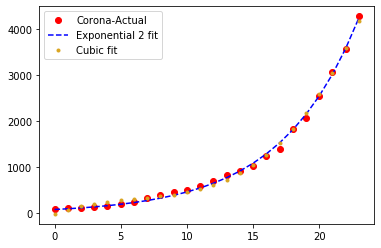

In [61]:
plt.plot(x_data, y_data, 'o', color ='red', label ="Corona-Actual") 

#plt.plot(x_data, exp_fit1, '--', color ='green', label ="Exponential 1 fit") # Bad Fit

plt.plot(x_data, exp_fit2, '--', color ='blue', label ="Exponential 2 fit") # Best fit

#plt.plot(x_data, exp_fit3, color ='goldenrod', label ="Exponential 3 fit") # very very bad fit

plt.plot(x_data, cubic_fit1, '.', color ='goldenrod', label ="Cubic fit") # Not so good fit

plt.legend() 
plt.show() 

## Parameters of best fit exponential curve fitting is : 

#### Conclusion 1: Exponential Curve fits best with the current  available dataset. 

Mathemathetical Model for Corona Spread in india is:  

\begin{equation} N(day_n)  = 85.05037381 * e^{day_n*0.17001928} \end{equation}


In [62]:
trace1 = go.Scatter(x=df['Date'],
                    y=df['Commulative Total Count of Confirmed Cases In India'],
                    name="Actual Data",
                    mode='lines+markers')

trace2 =  go.Scatter(x=df['Date'],
                    y=exp_fit2,
                    name="Exponential Fit",
                    mode='lines+markers')
trace3 =  go.Scatter(x=df['Date'],
                    y=cubic_fit1,
                    name="Cubit Fit",
                    mode='lines+markers')

data = [trace1, trace2, trace3]

layout = go.Layout(title='COVID-19: Commulative Total Count of Confirmed Cases In India : Exponential and Cubit Fit')

fig = go.Figure(data=data,layout=layout)

pyo.plot(fig,filename="InteractiveCharts/Comparing-Curve-Fittings.html")

'InteractiveCharts/Comparing-Curve-Fittings.html'

# Model Prediction in Future
This is hypothetical prediction, if the situation does remains same, then the spread will fit approximately as per the model. 

However, due to multiple (known/unknown) factors such as lockdown, awareness in people, increase in temperature etc. the model may over predict. Or may under-predict if the situations get out of hand.   


#### Extrapolating the model outcome 
Extrapolating the model outcome into Next <del>21 Days</del> 30 days i.e. 24th March to 30 April, 2020



In [63]:
len(df.index.values)
df.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
      dtype=int64)

In [64]:
x_hypo = df.index.values
x_hypo

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
      dtype=int64)

In [65]:
y_hypo = param_exponential_2[0] * np.exp(param_exponential_2[1] * x_hypo)


In [66]:
# Co-efficient Store:
# a * np.exp(b * x)
# (a,b) = (0.05895335,0.16472439)

# Comparing Trends
#### Comparing the exponential model trend vs the actual curve trend 

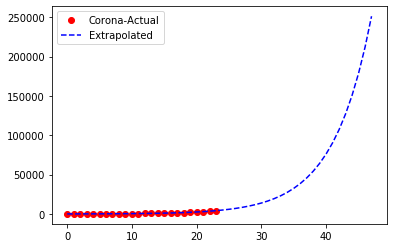

In [67]:
plt.plot(x_data, y_data, 'o', color ='red', label ="Corona-Actual") 
plt.plot(x_hypo, y_hypo, '--', color ='blue', label ="Extrapolated") 
plt.legend() 
plt.show() 

## Result: Plotly Interactive Chart 

In [68]:

trace_2 = go.Scatter(x=df['Date'],
                     y=y_hypo, 
                     name="Modeled", mode='lines+markers', line = dict(color='plum'))

trace_1 = go.Scatter(x=df['Date'],
                     y=df['Commulative Total Count of Confirmed Cases In India'],
                     name="Actual", line = dict(color='red', width=4, dash='solid') )


data = [trace_2, trace_1]

layout = go.Layout(title='Measuring Impact of #21DayLockdown on COVID-19 pandemic spread in India',
                   xaxis_title='Daily count of COVID-19 Spread in India',
                   yaxis_title='# of Cases')

fig = go.Figure(data=data, layout=layout)
pyo.plot(fig, filename="InteractiveCharts/COVID19-Cases-India-Compared01.html")





'InteractiveCharts/COVID19-Cases-India-Compared01.html'

### Store Extrapolated Data in a File

In [69]:
df_out = pd.DataFrame({'Date': list(df['Date'].values), 'Extrapolated': list(y_hypo)}, columns=['Date', 'Extrapolated'])
df_out.tail()

,Date,Extrapolated
43,2020-04-26,127270.822799
44,2020-04-27,150857.631515
45,2020-04-28,178815.729212
46,2020-04-29,211955.236818
47,2020-04-30,251236.413109


In [70]:
df_out.to_csv('data/covid19-extrapolated-cases-india.csv', index=False)

# Comparing Predictions
### Exponential model vs the actual trend

Let's compare the actual cases each day reported, everyday till 30th April and see how things progress. 

In [76]:
df_extrapolated = pd.read_csv('data/covid19-extrapolated-cases-india.csv', parse_dates=['Date'])
df_real         = pd.read_csv('data/covid19-total-cases-india.csv', parse_dates=['Date'])

In [77]:
df_extrapolated.tail()

,Date,Extrapolated
43,2020-04-26,127270.822799
44,2020-04-27,150857.631515
45,2020-04-28,178815.729212
46,2020-04-29,211955.236818
47,2020-04-30,251236.413109


In [78]:
df_real.tail()

,Date,Commulative Total Count of Confirmed Cases In India
43,2020-04-26,NaN
44,2020-04-27,NaN
45,2020-04-28,NaN
46,2020-04-29,NaN
47,2020-04-30,NaN


In [120]:
trace_2 = go.Scatter(x=df_extrapolated['Date'],
                     y=df_extrapolated['Extrapolated'], 
                     name="Modeled", mode='lines', line = dict(color='#00ccff', dash='dot', width=3))

trace_1 = go.Scatter(x=df_real['Date'],
                     y=df_real['Commulative Total Count of Confirmed Cases In India'],
                     name="Actual", mode='lines+markers',line = dict(color='red') )


data = [trace_2, trace_1]

layout = go.Layout( title=dict(text='Measuring Impact of #21DayLockdown on COVID-19 pandemic spread in India',
                               font=dict(color = '#ffdd00')
                              ),
                   xaxis_title='Daily commulative cases',
                   yaxis_title='# of Cases',
                   paper_bgcolor='#333',
                   plot_bgcolor='#333',
                   font=dict(size=14, color="#fff"  )
                   #font=dict(  family="Courier New, monospace", size=14, color="#7f7f7f"  )
                  )

fig = go.Figure(data=data, layout=layout)
pyo.plot(fig, filename="InteractiveCharts/COVID19-Cases-India-Compared02-Final.html")

'InteractiveCharts/COVID19-Cases-India-Compared02-Final.html'

In [81]:
df_extrapolated['Actual'] = df_real['Commulative Total Count of Confirmed Cases In India'] 
df_extrapolated['Extrapolated Minus Actual'] = df_extrapolated['Extrapolated'] - df_extrapolated['Actual']
df_extrapolated.tail(30)

,Date,Extrapolated,Actual,Predicted Minus Actual,Extrapolated Minus Actual
18,2020-04-01,1814.546171,1834.0,-19.453829,-19.453829
19,2020-04-02,2150.831837,2069.0,81.831837,81.831837
20,2020-04-03,2549.440552,2547.0,2.440552,2.440552
21,2020-04-04,3021.922503,3072.0,-50.077497,-50.077497
22,2020-04-05,3581.968447,3577.0,4.968447,4.968447
23,2020-04-06,4245.806416,4281.0,-35.193584,-35.193584
24,2020-04-07,5032.671949,NaN,NaN,NaN
25,2020-04-08,5965.365460,NaN,NaN,NaN
26,2020-04-09,7070.912913,NaN,NaN,NaN
27,2020-04-10,8381.348932,NaN,NaN,NaN
